In [4]:
import quandl
import numpy as np
import datetime as dt
import seaborn as sns
import calendar
import os
import pandas as pd
from pandas_datareader import data as pdr
import sys
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as mtick
import fix_yahoo_finance as yf
yf.pdr_override()
style.use('ggplot')

# Choose the Stocks and the Portfolio Allocations
x = ["EON", "ADS","BMW", "SAP", "TKA","HEN3"]
allocations = [25,25,25,25,25,25]

# Start and End Date

start_date = "2015-12-31"
end_date = "2018-04-19"

# get the stock data

In [5]:
def portfolio(x,start_date,end_date):
    main_df = pd.DataFrame()
    for abbv in x:
        liste = "FSE/"+str(abbv)+"_X.4"
        df = quandl.get(liste,start_date=start_date, end_date=end_date, authtoken='paPQhtsw_4qE95W_pUaa')
        df.rename(columns={'Close':str(abbv)}, inplace=True)
        if main_df.empty:
            main_df = df
        
        else:
            main_df = main_df.join(df) 
    
    port_data = main_df
    return port_data

In [7]:
portfolio(x,start_date,end_date).head()

,EON,ADS,BMW,SAP,TKA,HEN3
Date,,,,,,
2016-01-04,8.39,87.54,92.25,70.58,17.57,98.98
2016-01-05,8.48,87.24,91.82,71.43,17.72,98.68
2016-01-06,8.44,86.23,88.78,72.05,17.37,98.18
2016-01-07,8.20,84.89,85.44,71.34,16.75,96.01
2016-01-08,8.05,83.45,83.44,71.05,16.37,95.30


In [10]:
def portfoliovalue():
    port_val = portfolio(x,start_date,end_date)*allocations
    port_val = port_val.fillna(port_val.mean())
    port_val['Portfolio Value'] = port_val.sum(axis=1) 
    return port_val

## Calculate the Portfolio Value

In [12]:
portfoliovalue().head()

,EON,ADS,BMW,SAP,TKA,HEN3,Portfolio Value
Date,,,,,,,
2016-01-04,209.75,2188.50,2306.25,1764.50,439.25,2474.50,9382.75
2016-01-05,212.00,2181.00,2295.50,1785.75,443.00,2467.00,9384.25
2016-01-06,211.00,2155.75,2219.50,1801.25,434.25,2454.50,9276.25
2016-01-07,205.00,2122.25,2136.00,1783.50,418.75,2400.25,9065.75
2016-01-08,201.25,2086.25,2086.00,1776.25,409.25,2382.50,8941.50


## Portfolio Returns

In [14]:
def portfoliopct():
    port_rets = portfoliovalue().pct_change()
    port_rets = port_rets.dropna(how='any')
    return port_rets

portfoliopct().head()

,EON,ADS,BMW,SAP,TKA,HEN3,Portfolio Value
Date,,,,,,,
2016-01-05,0.010727,-0.003427,-0.004661,0.012043,0.008537,-0.003031,0.000160
2016-01-06,-0.004717,-0.011577,-0.033108,0.008680,-0.019752,-0.005067,-0.011509
2016-01-07,-0.028436,-0.015540,-0.037621,-0.009854,-0.035694,-0.022102,-0.022692
2016-01-08,-0.018293,-0.016963,-0.023408,-0.004065,-0.022687,-0.007395,-0.013705
2016-01-11,0.014907,0.021690,-0.003595,0.007741,-0.011607,-0.014061,0.001817


In [16]:
assets = portfoliovalue().tail(1)
s = portfoliovalue().iloc[-1:, -1]

In [29]:
assets.head()
s.head()

Date
2018-04-19    13145.4
Name: Portfolio Value, dtype: float64

In [18]:
def portfolioweigts():
    port_weights = assets / int(s)
    port_weights = port_weights.transpose()
    port_weights.columns = ["Weight"]
    port_weights = port_weights.drop(port_weights.index[len(port_weights) - 1])
    return port_weights

portfolioweigts()

,Weight
EON,0.017185
ADS,0.400342
BMW,0.172841
SAP,0.166812
TKA,0.043343
HEN3,0.199506


In [20]:
def benchmark():
    #bench_data = pdr.get_data_yahoo("^GDAXI", start_date="2015-12-31", end_date="2017-12-31")
    bench_data = pd.read_pickle('benchmark.dax.index')
    dates = pd.date_range(start='2015-12-31', end='2017-12-31')
    bench_data = pd.DataFrame(bench_data,index=dates, columns=['Close'])
    bench_data = bench_data.dropna(how='any')
    return bench_data

benchmark().head()

,Close
2016-01-04,10283.440430
2016-01-05,10310.099609
2016-01-06,10214.019531
2016-01-07,9979.849609
2016-01-08,9849.339844


In [23]:
def benchmarkpct():
    bench_rets = benchmark().pct_change()
    bench_rets = benchmark().dropna(how='any')
    return bench_rets

benchmarkpct().head()

,Close
2016-01-04,10283.440430
2016-01-05,10310.099609
2016-01-06,10214.019531
2016-01-07,9979.849609
2016-01-08,9849.339844


In [24]:
returns = portfoliopct().drop(columns=['Portfolio Value'])
cov_matrix = returns.cov()
mean_daily_returns = returns.mean()
num_portfolios = 50000
results = np.zeros((4 + len(x) - 1, num_portfolios))

In [25]:
for i in range(num_portfolios):
    weights = np.array(np.random.random(len(x)))
    weights /= np.sum(weights)
    
    portfolio_return = np.sum(mean_daily_returns * weights) * 252
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    results[0, i] = portfolio_return
    results[1, i] = portfolio_std_dev
    results[2, i] = results[0, i] / results[1, i]
    for j in range(len(weights)):
        results[j + 3, i] = weights[j]
        
    flds = ['ret', 'stdev', 'sharpe']
    lista = flds + x
    results_frame = pd.DataFrame(results.T, columns=lista)
    max_sharpe_port = results_frame.iloc[results_frame['sharpe'].idxmax()]
    min_vol_port = results_frame.iloc[results_frame['stdev'].idxmin()]
    
print(results_frame)
print( "-------------Max Sharpe Portfolio------------")
print(max_sharpe_port)
print('\n')
print("-------------Minimum Variance Portfolio------------")
print(min_vol_port)
  

            ret     stdev    sharpe       EON       ADS       BMW       SAP  \
0      0.159225  0.161858  0.983736  0.125448  0.223772  0.053179  0.248940   
1      0.099762  0.175889  0.567184  0.115817  0.050338  0.211315  0.217596   
2      0.089444  0.200957  0.445092  0.346568  0.067923  0.332124  0.066315   
3      0.114954  0.186144  0.617555  0.131701  0.074213  0.237972  0.243487   
4      0.101408  0.187475  0.540914  0.166340  0.045840  0.191077  0.122355   
5      0.096747  0.199477  0.485004  0.305141  0.051875  0.290518  0.173022   
6      0.139464  0.185496  0.751842  0.226578  0.135531  0.002082  0.091869   
7      0.152373  0.168891  0.902197  0.162065  0.236698  0.225075  0.214977   
8      0.105047  0.197677  0.531404  0.318875  0.038264  0.163214  0.279398   
9      0.134259  0.176050  0.762618  0.079495  0.145428  0.185357  0.148526   
10     0.185741  0.166436  1.115990  0.178220  0.320072  0.063091  0.224177   
11     0.166964  0.166392  1.003436  0.208527  0.256

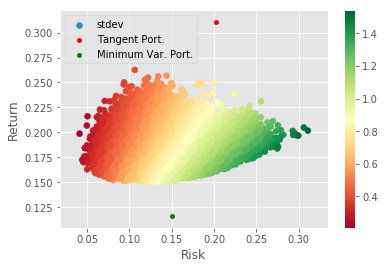

In [28]:
def scatterplot():
    plt.scatter(results_frame.ret,results_frame.stdev,c=results_frame.sharpe,cmap='RdYlGn')
    plt.xlabel('Risk')
    plt.ylabel('Return')
    plt.colorbar()
    plt.scatter(max_sharpe_port[1],max_sharpe_port[0], marker='o', color='r',s=20, label = 'Tangent Port.')
    plt.scatter(min_vol_port[1],min_vol_port[0], marker='o', color='g',s=20, label='Minimum Var. Port.')
    plt.legend()
    plt.show()
    
scatterplot()    

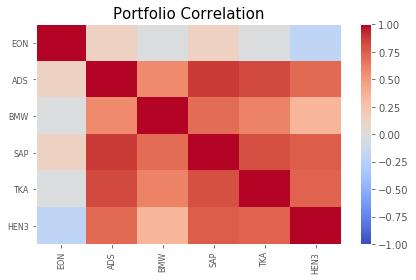

In [32]:
def correl():
    cor = portfolio(x,start_date,end_date).corr()
    data = cor.values
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    heatmap = ax.pcolor(data, cmap =plt.cm.coolwarm)
    fig.colorbar(heatmap)
    ax.set_xticks(np.arange(data.shape[0]) + 0.5, minor=False)
    ax.set_yticks(np.arange(data.shape[0]) + 0.5, minor=False)
    ax.invert_yaxis()
    
    column_labels = cor.columns
    row_labels = cor.index

    ax.set_xticklabels(column_labels, rotation=90, fontsize=8)
    ax.set_yticklabels(row_labels, fontsize=8)
    heatmap.set_clim(-1, 1)
    plt.title('Portfolio Correlation', fontsize=15)
    plt.tight_layout()
    
correl()    

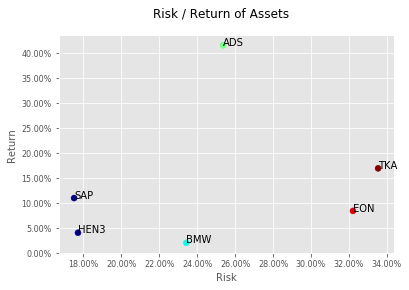

In [34]:
def risk_return():
    x = (portfoliopct().std()*np.sqrt(252))*100
    x = x[:-1]
    y = (portfoliopct().mean() * 252) * 100
    y = y[:-1]
    n = y.index
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    t = x
    ax.scatter(x, y, c=t, cmap='jet')

    fmt = '%.2f%%'  # Format you want the ticks, e.g. '40%'
    xticks = mtick.FormatStrFormatter(fmt)
    ax.xaxis.set_major_formatter(xticks)
    ax.yaxis.set_major_formatter(xticks)

    for i, txt in enumerate(n):
        ax.annotate(txt, (x[i], y[i]))

    plt.suptitle("Risk / Return of Assets")
    plt.xlabel("Risk", fontsize=10)
    plt.ylabel("Return", fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.show()
    
risk_return()    

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


AttributeError: module 'matplotlib.pyplot' has no attribute 'subtitel'

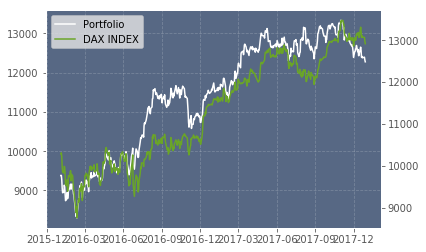

In [35]:
def peformance():
    portfoliovalues = portfoliovalue()
    benchmarkvalue = benchmark()
    perf = benchmarkvalue.join(portfoliovalues['Portfolio Value'])
    perf.rename(columns={'Close':'Benchmark Value'}, inplace=True)
    
    port_data = perf['Portfolio Value']
    bench_data = perf['Benchmark Value']
    
    fig = plt.figure()
    ax = fig.add_subplot(111,axisbg='#576884')
    lns1 = ax.plot(port_data, linestyle='-', color="white", label='Portfolio')
    
    x = port_data.index
    y = port_data[0:len(port_data)]
    q = bench_data.index
    z = bench_data[0:len(bench_data)]
    
    ax2 = ax.twinx()
    ax2.grid(None)
    lns2 = ax2.plot(bench_data, linestyle='-', color='#6aa527', label='DAX INDEX')
                    
    lns = lns1 + lns2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc=0)
    ax.grid(linestyle='--', alpha=0.2)                
    plt.subtitel('Portfolio Performance vs. Benchmark')
    
peformance()    

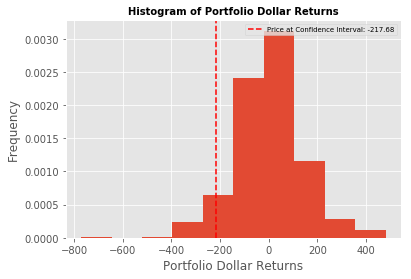

99.99% Confident the actual loss will not exceed: -753.71
99% Confident the actual loss will not exceed: -319.55
95% Confident the actual loss will not exceed: -217.68
Losses expected to exceed -217.68 28.8 out of 576 days


In [36]:
def port_var():
    
    investments_amts = [1000,2000,3000,2500,2000,2500]
    port_pct = portfoliopct()[x]
    port_val = port_pct * investments_amts
    port_val['Portfolio Value'] = port_val.sum(axis=1)
    
    port_rets = port_val['Portfolio Value']
    port_rets = port_rets.sort_values(axis=0, ascending=True)
    
     
    var =  np.percentile(port_rets, .01)
    var1 =  np.percentile(port_rets, 1)
    var2 =  np.percentile(port_rets, 5)
    
    plt.hist(port_rets,normed=True)
    plt.xlabel('Portfolio Dollar Returns')
    plt.ylabel('Frequency')
    plt.title(r'Histogram of Portfolio Dollar Returns', fontsize=10, fontweight='bold')
    plt.axvline(x=var2, color='r', linestyle='--', label='Price at Confidence Interval: ' + str(round(var2, 2)))
    plt.legend(loc='upper right', fontsize = 'x-small')
    plt.show() 
    
    print ("99.99% Confident the actual loss will not exceed: " + str(round(var, 2)))
    print ("99% Confident the actual loss will not exceed: " + str(round(var1, 2)))
    print ("95% Confident the actual loss will not exceed: " + str(round(var2, 2)))
    
    print ("Losses expected to exceed " + "{0:.2f}".format(var2) + " " + str(.05*len(port_rets)) + " out of " + str(len(port_rets)) + " days")
    
port_var()    